# Exercício 2 - Enunciado


2. O Conway’s Game of Life é um exemplo conhecido de um autómato celular . Aqui vamos modificar as regras do autómato de forma a usar um espaço de estados finito
    1. O espaço de estados é definido por uma grelha de células booleanas (morta=0/viva=1) de dimensão $\,N\times N\,$ (com $N>3$) identificadas por índices $\,(i,j)\in \{1..N\}$.  Estas $\;N\uparrow2\;$ células são aqui referidas como “normais”. 
    2. Inicialmente todas as células normais estão mortas excepto  as células $\,i,j \leq 3\,$que estão vivas. Um estado onde todas as células normais estão mortas é um “estado de erro”.
    3. Adicionalmente existem $\,2\,N+1\,$ “células da borda” que correspondem a um dos índices, $i$ ou $j$, ser zero. As células da borda têm valores constantes que, no estado inicial, são gerados aleatoriamente com uma probabilidade $\,1/2\,$ de estarem vivas.
    4. As células normais o autómato modificam o estado de acordo com a regra “B3/S23”: i.e. a célula nasce (passa de $0$ a $1$) se tem exatamente 3 vizinhos vivos e sobrevive (mantém-se viva) se o número de vizinhos vivos é 2 ou 3, caso contrário morre ou continua morta.

*A célula $\;(i_0,j_0)\;$e $\,(i_1,j_1)\,$ são vizinhas sse $\;(i_0-i_1=\pm 1) \,\lor\, (j_0-j_1 = \pm 1)$*

Pretende-se:

    1. Construir uma máquina de estados finita que represente este autómato.
    2. Provar as seguintes propriedades:
        1. Nunca se alcança o estado de erro
        2. Nenhuma célula normal está permanentemente morta ou permanentemente viva.


# Exercício 2 - Solução

Pretendemos construir a FSM que representa o autómato celular do GoL (Game of Life) e provar as duas propriedades do enunciado.

No entanto, de forma a verificar o funcionamento esperado deste autómato, começemos pela criação da FSM e com a criação de código que procure animar o autómato.

## Criação da FSM e Animação do GoL

In [1]:
from pysmt.shortcuts import Solver, Symbol,  And, Or, Implies, Not
from pysmt.shortcuts import Equals, Int, GT, LE, LT, Plus, Minus
from pysmt.shortcuts import is_sat, get_model, AllDifferent
from pysmt.typing import INT
from random import choices
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

Começemos por definir uma classe que defina os estados deste autómato.

Nesta conceção de estado, teremos informação sofre quais células estão vivas e em que elemento do traço nos encontramos.

In [2]:
class ST:
    def __init__(self, s=''):
        self.table = []
        self.living = []
        self.border = []
        self.pc = Symbol(s+'.pc', INT)
    def __str__(self):
        return f"({str(self.living), str(self.border)},  {str(self.pc)})"

Consideremos $N = \{0,\dots,9\}$, teremos o conjunto $N \uparrow 2$ de cardinalidade $100$ com um total de $121$ células incluindo as *Border Cells*.

Ora, com isto, criemos o tabuleiro de jogo:

In [3]:
N = 10
table = [[Symbol('c'+str(i)+','+str(j)) for j in range(N+1)] for i in range(N+1)]

Note-se também que o "Jogo da Vida" de Conway é **indecidível**, sendo assim, a cardinalidade do traço tenderá para o infinito.

Sendo assim, limitemos superiormente a execução por um número arbitrário:

In [4]:
M = 100

trace= [ST('ST'+str(i)) for i in range(M+1)]

Teremos então de inicializar a tabela com os requisitos, começemos por diferenciar células normais de células de fronteira:

```python
live_init_ncell = {table[1][1],table[1][2],table[1][3],
                  table[2][1],table[2][2],table[2][3],
                  table[3][1],table[3][2],table[3][3]}
bcell = set()
for i in range(N+1):
    for j in range(N+1):
        if i == 0 or j == 0:
            bcell.add(table[i][j])
dead_init_ncell = {table[i][j] for i in range(N+1)
                   for j in range(N+1)
                    if table[i][j] not in live_init_ncell and table[i][j] not in bcell}
```

Com isto podemos definir a configuração inicial das células normais através de uma simples restrição lógica:

`prob = And(Not(And(dead_init_ncell)),And(live_init_ncell))`

Com isto, podemos proceder a inicializar as células que se encontram na fronteira.

Ora, estas são inicializadas de forma aleatória com uma probabilidade de nascer de $\frac{1}{2}$.

De notar que uma biblioteca Standard (`random`) contem a subrotina (`choices`) que permite gerar resultados aleatórios com pesos.

```python
distribution = [choices([False,True], [0.5,0.5]) for i in range(2*N+1)]
bcell_list = list(bcell)
for i in range(len(bcell_list)):
    if distribution[i][0]:
        prob = And(prob, bcell_list[i])
    else:
        prob = And(prob, Not(bcell_list[i]))
```

Com isto podemos definir a função init que coinciderá com o estado I da nossa máquina de estado finita:

In [5]:
I = Int(0)
E  = Int(1)

def init(N, table, trace):
    live_init_ncell = set()
    bcell = set()
    dead_init_ncell = set()

    live_init_ncell = {table[1][1],table[1][2],table[1][3],
                  table[2][1],table[2][2],table[2][3],
                  table[3][1],table[3][2],table[3][3]}
    for i in range(N+1):
        for j in range(N+1):
            if i == 0 or j == 0:
                bcell.add(table[i][j])
    dead_init_ncell = {table[i][j] for i in range(N+1)
                                   for j in range(N+1)
                            if table[i][j] not in live_init_ncell 
                                           and table[i][j]
                                           not in bcell}
    const_dead = Not(And(dead_init_ncell))
    const_live = And(live_init_ncell)
    normal = And(const_dead, const_live)
    #print(normal)
    
    distribution = [choices([False,True], [1/2,1/2]) for i in range(2*N+2)]
    bcell_list = list(bcell)
    if distribution[0][0]:
        bord = And(bcell_list[0])
    else:
        bord = And(Not(bcell_list[0]))
    for i in range(1, len(bcell_list)):
        if distribution[i][0]:
            bord = And(bord, bcell_list[i])
        else:
            bord = And(bord, Not(bcell_list[i]))
    global_const = And(normal, bord)
    
    trace[0].table = table;
    global_const = And(global_const, Equals(trace[0].pc, I))
    return global_const

Agora, de forma a podermos implementar uma função de transição,
procederemos com a implementação de alguma subrotina que
conte o número de células vizinhas vivas:

In [6]:
def living_neigh(s, study, N):
    x, y = study
    # study_x != 0 study_y != 0
    # i_0 - i_1 = +- 1 OR j_0 - j_1 = +- 1
    living = []
 
    # normal line normal column
    if (x > 0 and x < N) and (y > 0 and y < N):
        for i in range(x-1,x+2):
            for j in range(y-1,y+2):
                if (abs(x-i) == 1 or abs(y-j) == 1):
                    if (s.table[i][j] in s.living or s.table[i][j] in s.border):
                        living.append((i,j))
    # final column normal line
    elif (x == N and y < N):
        for i in range(x-1,x):
            for j in range(y-1,y+2):
                if (abs(x-i) == 1 or abs(y-j) == 1):
                    if (s.table[i][j] in s.living or s.table[i][j] in s.border):
                        living.append((i,j))
    # final column final line
    elif (x == N and y == N):
        for i in range(x-1,x):
            for j in range(y-1,y+1):
                if (abs(x-i) == 1 or abs(y-j) == 1):
                    if (s.table[i][j] in s.living or s.table[i][j] in s.border):
                        living.append((i,j))
    return len(living);

Previamente definimos 5 variáveis, `I` e `E`, que serão úteis na definição da nossa Máquina de Estados.
Sendo assim temos uma Máquina de Estados finita definida do seguinte modo:
$$\langle Q, \delta, S \rangle\ ;\ Q := \{I, E\}\ ,\ \delta := \{ (I,I), (I,E)\}\ ,\ S := \{I\} $$

In [7]:
def update_table(s, s_, N):
    prob = And(s.border)
    for i in range(1, N+1):
        for j in range(1, N+1):
            study = (i,j)
            n_nei = living_neigh(s, study, N)
            if n_nei == 3 and s.table[i][j] not in s.living:
                prob = And(prob, s.table[i][j])
            elif (n_nei < 2 or n_nei > 3) and s.table[i][j] in s.living:
                prob = And(prob, Not(s.table[i][j]))
            elif s.table[i][j] not in s.living:
                prob = And(prob, Not(s.table[i][j]))
            else:
                prob = And(prob, s.table[i][j])
    s_.table = s.table
    return prob
                

In [8]:
def trans(s, s_, N):
    t00 = And(Equals(s.pc, I),
              Equals(s_.pc, I),
              update_table(s, s_, N))
    return Or(t00) #, t0E)


Estamos finalmente em vias de resolver algum modo de animar o nosso problema, tentaremos,
então animar a primeira configuração do Autómato Celular a ser estudado:

In [9]:
def generate_trace(trace, M, init, N):
    init = init(N,table,trace)
    with Solver() as solver:
        res = False;
        prop = init
        for t_ind in range(M):
            state = trace[t_ind]
            solver.push()
            solver.add_assertion(prop);
            if solver.solve():
                trace[t_ind].living = [trace[t_ind].table[i][j]
                                       for j in range(1,N+1)
                                       for i in range(1, N+1)
                                       if solver.get_value(trace[t_ind].table[i][j]).constant_value()]
                trace[t_ind].border = [trace[t_ind].table[i][j]
                                       for j in range(N+1)
                                       for i in range(N+1)
                                       if (i == 0 or j == 0)
                                    and solver.get_value(trace[t_ind].table[i][j]).constant_value()]
                prop = trans(trace[t_ind], trace[t_ind+1], N)
            solver.pop()

In [10]:
def animate_trace(trace, t_ind, N):
    state = trace[t_ind]
    living = list()
    for i in range(N+1):
        living.append([])
        for j in range(N+1):
            if (state.table[i][j] in state.living
                or state.table[i][j] in state.border):
                living[i].append(True)
            else:
                living[i].append(False)
    plt.matshow(living , cmap='gray')


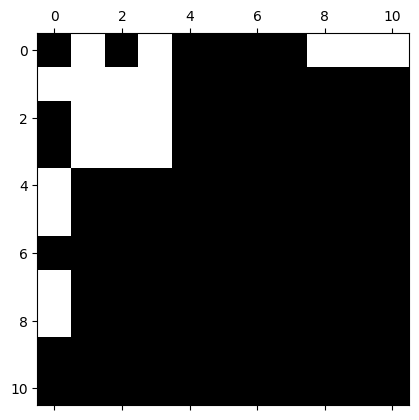

In [11]:
generate_trace(trace, M, init, N)
for i in range(1):
    animate_trace(trace, i, N)

## Verificação das Propriedades

In [12]:
def bmc_always(trans,inv,K,N,trace, init, table):
    for k in range(1,K-1):
        with Solver(name="z3") as s:
            s.add_assertion(init(N,table,trace))
            for i in range(k-1):
                s.add_assertion(trans(trace[i], trace[i+1],N))
            s.add_assertion(inv(trace[k-1]))
            if s.solve():
                print("A propriedade é inválida")
                print([state.living for state in trace])
                return
    print("A propriedade é válida")

In [13]:
def bmc_eventually(init, trans,prop,M,N,trace, table):
    for k in range(1,M):
         with Solver(name="z3") as s:
            s.add_assertion(init(N,table,trace))
            for i in range(k-1):
                s.add_assertion(trans(trace[i], trace[i+1],N))
            
            for i in range(k):
                s.add_assertion(prop(trace,k,N))
            
            s.add_assertion(Or(trans(trace[k-1],trace[i],N) for i in range(k)))
            
            if s.solve():
                print("Propriedade é inválida")
                print([state.living for state in trace])
                return
            
    print("A propriedade é válida")

Consideremos as proposições que queremos provar:

        1. Nunca se alcança o estado de erro
        2. Nenhuma célula normal está permanentemente morta ou permanentemente viva.

Ou seja:

        1. Existe sempre uma célula viva em qualquer estado do traço;
        2. Eventualmente, todas as células da tabela vão alterar de estado pelo menos uma vez ao longo do traço.

Isto é:

        1. A variável `living` estar vazia em algum estado do traço é unsat;
        2. Existir alguma célula invariável ao longo do traço é unsat.

In [14]:
def prop1(state):
    return Equals(Int(len(state.living)), Int(0))

In [15]:
bmc_always(trans,prop1,M,N,trace, init, table)

#for i in range(M):
#    animate_trace(trace, i, N)

A propriedade é válida


In [16]:
def prop2(trace, M, N):
    al_li = []
    for i in range(1,N+1):
        for j in range(1, N+1):
            for k in range(1,M):
                if trace[k].table[i][j] not in trace[k].living:
                    break;
            else:
                al_li.append(table[i][j])
                pass
    al_de = []
    for i in range(1,N+1):
        for j in range(1, N+1):
            for k in range(1,M):
                if trace[k].table[i][j] in trace[k].living:
                    break;
            else:
                al_de.append(table[i][j])
                pass
    return And(And(al_li), And(al_de))

In [17]:
bmc_eventually(init, trans,prop2 ,M,N,trace, table)

A propriedade é válida
